> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (No Show Appointments)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. In order to work with the data in this workspace, you also need to upload it to the workspace. To do so, click on the jupyter icon in the upper left to be taken back to the workspace directory. There should be an 'Upload' button in the upper right that will let you add your data file(s) to the workspace. You can then click on the .ipynb file name to come back here.

> **Questions Asked**: We asked Three Questions:
> 1- HOW MANY PEOPLE RECEIVED SMSs THAT HAVE HIPERTENSION?
> 2- HOW MANY PEOPLE HAVE DIABETES AND DIDN'T SHOW UP?
> 3- HOW MANY PEOPLE OF EACH GENDER DIDN'T SHOW UP?

In [69]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [70]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [71]:
#Gives Info For The Dataset
df.info

<bound method DataFrame.info of            PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
5       9.598513e+13        5626772      F  2016-04-27T08:36:51Z   
6       7.336882e+14        5630279      F  2016-04-27T15:05:12Z   
7       3.449833e+12        5630575      F  2016-04-27T15:39:58Z   
8       5.639473e+13        5638447      F  2016-04-29T08:02:16Z   
9       7.812456e+13        5629123      F  2016-04-27T12:48:25Z   
10      7.345362e+14        5630213      F  2016-04-27T14:58:11Z   
11      7.542951e+12        5620163      M  2016-04-26T08:44:12Z   
12      5.666548e+14        5634718      F  2016-04-28T11:33:51Z   
13      9.113946

In [72]:
#Gives The Shape Of The Dataset
df.shape

(110527, 14)

In [73]:
#Describes the Dataset 
df.describe

<bound method NDFrame.describe of            PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
5       9.598513e+13        5626772      F  2016-04-27T08:36:51Z   
6       7.336882e+14        5630279      F  2016-04-27T15:05:12Z   
7       3.449833e+12        5630575      F  2016-04-27T15:39:58Z   
8       5.639473e+13        5638447      F  2016-04-29T08:02:16Z   
9       7.812456e+13        5629123      F  2016-04-27T12:48:25Z   
10      7.345362e+14        5630213      F  2016-04-27T14:58:11Z   
11      7.542951e+12        5620163      M  2016-04-26T08:44:12Z   
12      5.666548e+14        5634718      F  2016-04-28T11:33:51Z   
13      9.1139

In [74]:
#Also Describes The Dataset But In A Better Shape
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [75]:
#Gives a View Of Unique Values in Each Category of The Dataset Which will Allow me to check if I need To Clean The Data
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

In [76]:
# Checks For Any Missing Values In The Dataset
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [77]:
#Checks Whether The Dataset Has Duplicated Valuer
sum(df.duplicated())

0

In [78]:
#Checks if there is any negative value in the Age Column
df.Age.max(), df.Age.min()

(115, -1)

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (We Will Work on Cleaning a Couple of things in our Dataset to make it Look Better. More details are mentioned in the notes below.)

# After discussing the structure of the data and any problems that need to be cleaned, perform those cleaning steps in the second part of this section.

## I have to allocate the row where there is a value of (-1) in the age so that I can Clean it


In [79]:
df.query('Age == -1')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


# After Identifing its place, We need to drop it from the dataset

In [80]:
df.drop(df.index[99832],inplace=True)

## To Check if the Previous step has been implemented Properly

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110526 non-null float64
AppointmentID     110526 non-null int64
Gender            110526 non-null object
ScheduledDay      110526 non-null object
AppointmentDay    110526 non-null object
Age               110526 non-null int64
Neighbourhood     110526 non-null object
Scholarship       110526 non-null int64
Hipertension      110526 non-null int64
Diabetes          110526 non-null int64
Alcoholism        110526 non-null int64
Handcap           110526 non-null int64
SMS_received      110526 non-null int64
No-show           110526 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 12.6+ MB


## The Number of Rows decreased from 110527 to 110526 so this means that we are on the right track

## To Check The header in order to change their names

In [82]:
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


## It's better to change certain names in headers for it to be easier on the eye to read

In [83]:
df.rename(columns={'PatientId':'Patient_ID', 'AppointmentID': 'Appointment_ID', 'ScheduledDay': 'Scheduled_Day', 'AppointmentDay': 'Appointment_Day'}, inplace= True)

In [84]:
df.head(1)

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


# Now that's a lot better :D

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (HOW MANY PEOPLE RECEIVED SMSs THAT HAVE HIPERTENSION?)

In [85]:
df.groupby(["SMS_received", "Hipertension"]).size()

SMS_received  Hipertension
0             0               60113
              1               14931
1             0               28612
              1                6870
dtype: int64

## Answering the question above:
### 1st question showed that 60113 People didn't recieve an SMS and don't have hipertension
### Also that 14931 People have Hipertensiom but didn't Recieve an SMS As well
## It Showed that 28612 recieved SMSs that didn't have hipertension while 6870 recieved SMSs while having hipertension

## Its Plot Will Look As Follows:

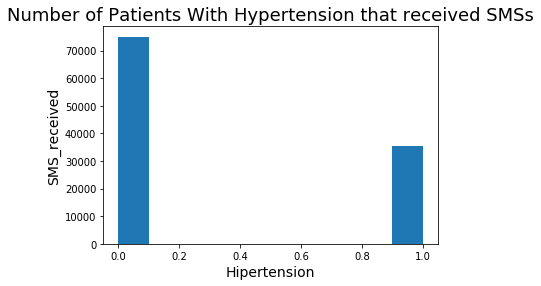

In [86]:
#Plotting The Data
first_plot=df['SMS_received'].plot(kind='hist')
plt.xlabel('Hipertension', fontsize= 14)
plt.ylabel('SMS_received', fontsize= 14)
plt.title('Number of Patients With Hypertension that received SMSs', fontsize= 18)
plt.show()

### Research Question 2  (HOW MANY PEOPLE HAVE DIABETES AND DIDN'T SHOW UP? )

In [87]:
df.groupby(["No-show", "Diabetes"]).size()

No-show  Diabetes
No       0           81694
         1            6513
Yes      0           20889
         1            1430
dtype: int64

# 2nd question showed that 81694 People didn't show up and don't have diabetes
## Also that 6513 People have Diabetes but didn't show up
### It Showed that 20889 showed up and didn't have diabetes while 1430 showed up while having diabetes

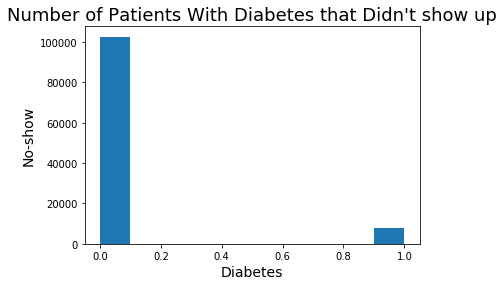

In [88]:
#Plotting The Data
second_plot=df['Diabetes'].plot(kind='hist')
plt.xlabel('Diabetes', fontsize= 14)
plt.ylabel('No-show', fontsize= 14)
plt.title('Number of Patients With Diabetes that Didn\'t show up', fontsize= 18)
plt.show()

### Research Question 3  (HOW MANY PEOPLE OF EACH GENDER DIDN'T SHOW UP? )

In [89]:
gender_value = pd.get_dummies(df['Gender'])
gender_value.head()

,F,M
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [90]:
df= pd.concat([df,gender_value], axis=1)
df.head()

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,F,M
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,1
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,1,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1,0


In [91]:
df.drop(['Gender'], axis=1, inplace = True)

In [92]:
df.head(5)

,Patient_ID,Appointment_ID,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,F,M
0,2.987250e+13,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1,0
1,5.589978e+14,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,1
2,4.262962e+12,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,1,0
3,8.679512e+11,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1,0
4,8.841186e+12,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1,0


In [93]:
df.groupby(['No-show','F']).size()

No-show  F
No       0    30962
         1    57245
Yes      0     7725
         1    14594
dtype: int64

# 3rd question showed that 30962 Males didn't show up while 57245 Females didn't show up.
## Also that 7725 Males showed up while 14594 Females Showed up.

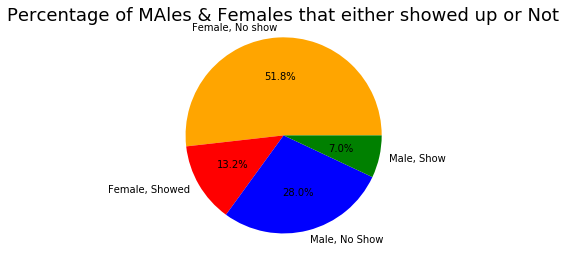

In [94]:
# Setting Pie-Chart Properties
labels = 'Female, No show', 'Female, Showed', 'Male, No Show', 'Male, Show'
cut_points = [57245, 14594, 30962, 7725 ]
colors = ['orange', 'red', 'blue', 'green']

#Set piechart title and axis
fig1, ax = plt.subplots()
ax.pie(cut_points, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of MAles & Females that either showed up or Not', fontsize= 18)

ax.axis('equal')

#plot piechart
plt.show()

## Graph Analysis
### The Graph shows that 51.8% of the patients were Females that didn't show to their appointments while only 13.2% of the patients were Females that actully showed up.
#### It Also showed that 28% of the patients were males that didn't show up while 7% of the patuents were males that actually showed up to their appointments.

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

## I gave a proper explanation of my findings in the attached PDF File but for references, I will add the Conclusion here.
#### From the analysis conducted above and after asking 3 questions which were:
##### 1-HOW MANY PEOPLE RECEIVED SMSs THAT HAVE HIPERTENSION?
##### 2-HOW MANY PEOPLE HAVE DIABETES AND DIDN'T SHOW UP?
##### 3-HOW MANY PEOPLE OF EACH GENDER DIDN'T SHOW UP?
###### We reached out the following conclusions:
###### -More People Didn't receive SMSs that didn't have Hypertension than PEople That Received SMSs with Hypertension.
###### -More People Didn't Show up to their appointments that didn't have have diabetes than people who showed up and had diabetes.
###### -Finally it showed that 51.8% of the patients were Females that didn't show to their appointments while only 13.2% of the patients were Females that actully showed up.

### Limitations Sub-section
#### From working on this project, I think the limitations were as follows:
##### 1-I needed to adjust several areas in the dataset itself and even dropping a line which had age in (-ve) value along with several other points.
##### 2-I think that the age of the patients could have been categorized so that it could appear in a better readable manner and easier for analysis.

In [95]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0